# Pildikalkulaator (<i>Picture Calculator</i>)

Autorid: Sille Habakukk, Ilmar Uduste

Projekti eesmärk oli luua programm, mis suudaks pildi pealt tuvastada matemaatilisi tehteid, neid Pythonisse sisse lugeda, arvutus lõpuni teha ning lõppvastus anda. Funktsionaalsus oleks seega sarnane Photomath äpile.

Põhiline fookus läks programmi arendamisel GUIga versiooni peale, aga LTAT.01.003 Tehisintellekt raames tekitasime ka Google Colabiks sobiliku .ipynb faili. Kahjuks ei jõudnud antud õppeaine raames programmi esialgse planeeritud võimekuseni viia, kuid loodetavasti piisab sellest miniprojekti jaoks. :)

Allpool on toodud pilt GUIst, mis on kättesaadaval meie projekti Githubis: https://github.com/ilmaruduste/picture_calculator/blob/dev/math_symbol_classification_ml.ipynb

![Pilt GUIst](gui_pic.png)

# Ettevalmistus
## Moodulite import

In [3]:
import os.path
import cv2
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
import sys
import math

## Kasutatud funktsioonid

In [4]:
######## DEFINE FUNCTIONS ########
#sorteerib kastid nende x koordinaadi väärtuse põhjal
#st. et eeldame et tehe on kirjutatud ühes reas
def order_boxes(boxes):
    boxes.sort(key=lambda x:x[0])

# def get_areas(boxes):
#     areas = []
#     for box in boxes:
#         areas.append(box[2]*box[3])
#     return areas

#eemaldab bounding boxid mis on teiste bounding boxide sees
def remove_inside_boxes(boxes):
    remove_boxes = []
    for box_has_parent in boxes:
        xc,yc,wc,hc = box_has_parent
        for box_parent in boxes:
            xp,yp,wp,hp = box_parent
            if xc>=xp and yc>=yp and xp+wp>=xc+wc and yp+hp>=yc+hc and box_has_parent != box_parent:
                remove_boxes.append(box_has_parent)
    for box in remove_boxes:
        boxes.remove(box)
    return boxes

#lõikab bounding boxide põhjal välja pildist huvipakkuvad pildid
def get_crops(image, boxes, draw=False):
    crops = []
    for box in boxes:
        x,y,w,h = box
        crops.append(image[y:y+h,x:x+w])
    if draw:
        for i, crop in enumerate(crops):
            plt.subplot(1,len(crops),i+1)
            #plt.axis('off')
            plt.imshow(crop, cmap="gray")
    return crops

#muudab pildid listis ruudukujuliseks, lisades puhvrit ümber
def make_square(image_list, square_size=None):
    ruudud = []
    for image in image_list:
        h, w = image.shape
        og_square_edge = max(h,w)
        if h > w:
            pool = (h-w)//2
            #vasakule liidetav pilt, laiusega pool, kõrgusega h, värv 255
            vasakule = np.full((h,pool), 255)
            #paremale liidetav pilt, laiusega h-w-pool, kõrgusega h, värv 255
            paremale = np.full((h,h-w-pool), 255)
            ruudud.append(np.concatenate((vasakule,image,paremale), axis=1))
        else:
            pool = (w-h)//2
            #ules liidetav pilt, laiusega w, kõrgusega pool, värv 255
            ules = np.full((pool, w), 255)
            #alla liidetav pilt, laiusega w, kõrgusega w-h-pool, värv 255
            alla = np.full((w-h-pool, w), 255)
            ruudud.append(np.concatenate((ules,image,alla), axis=0))
      
    #vajadusel muudab ruutude suurust
    if square_size != None:
        lopp_ruudud = []
        for image in ruudud:
            lopp_ruudud.append(cv2.resize(np.array(image, dtype='uint8'), (square_size, square_size), interpolation=cv2.INTER_AREA))
        ruudud = lopp_ruudud
    return ruudud

#väljalõigatud piltide visualiseerimiseks
def draw_crops(crops, draw_axis='on'):
    for i, crop in enumerate(crops):
            plt.subplot(1,len(crops),i+1)
            plt.axis(draw_axis)
            plt.imshow(crop, cmap="gray")
            # plt.imshow(crop)

## Mudeli sisselaadimine

Laeme sisse tehisnärvivõrgu, mille arendus on notebookis math_symbol_classification_ml.ipynb. NN treeningandmestikuks kasutasime [Kaggle'ist leitud andmestikku](https://www.kaggle.com/xainano/handwrittenmathsymbols) ning edasine töö on seal samas notebookis kirjas.

In [16]:
######## LOAD MODEL AND LABELS ########
loaded_model = keras.models.load_model('./math_symbol_classifier_model_v6')
labels_df = pd.read_csv('labels_df_6.csv', sep=';')

labels_df.drop(labels_df.columns[0], axis=1, inplace=True)
true_labels = np.array(labels_df['true_label'])

# Pilditöötlus

Pildikalkulaatori esimene samm on pilditöötlus.

## Pildi sisselugemine

Testimiseks kasutatud pildid leiab siit:
https://drive.google.com/drive/folders/1DgyAjqd-hFdPVKjGqwXlpsRn4YtYqpwl 

In [9]:
filename = 'test_images/bigger_all_numbers.png'

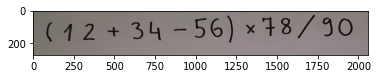

In [10]:
img = cv2.imread(filename)
plt.imshow(img)

## Pildi töötlemine
Eemaldame müra, suurendame kontrasti, leiame numbrite kontuurid, mille põhjal leiame ümbritsevad kastid.
Ümbritsevad kastid aitavad hiljem pildist välja lõigata osad, mida mudel peab ennustama tehtemärkideks ja numbriteks.

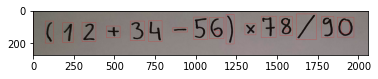

In [57]:
def pildi_tootlus(img):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  #blurimine vajalik et eemaldada müra
  blur_img = cv2.GaussianBlur(img_gray,(5,5),0)
  #thresholdimisega teeme hallist taustast valge ja tekstist musta
  ret, thresh = cv2.threshold(blur_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  # paksendan jooni kõvasti, et lähedalolevad sümbolid (nt võrdusmärgid) muutuksid üheks
  kernel = np.ones((13,13),np.uint8)
  thresh_dilate = cv2.erode(thresh, kernel, iterations=1)

  contours,hierarchy = cv2.findContours(thresh_dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  # contours,hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  boxed_img = img.copy()
  joined_boxes = []
  for cnt in contours:
      x,y,w,h = cv2.boundingRect(cnt)
      # kui kast ei ole terve pildi suurune siis lisame jälgitavasse
      if w < img_gray.shape[1] and h < img_gray.shape[0]:
          joined_boxes.append([x,y,w,h])
      boxed_img = cv2.rectangle(boxed_img,(x,y),(x+w,y+h),(255,0,0),1)

  joined_boxes = remove_inside_boxes(joined_boxes)

  imgbytes = cv2.imencode(".png", boxed_img)[1].tobytes()
  plt.imshow(boxed_img)

  return thresh, joined_boxes

thresh, joined_boxes = pildi_tootlus(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


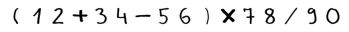

In [65]:
order_boxes(joined_boxes)
crops = get_crops(thresh, joined_boxes, True)

crops = make_square(crops)
tiny_crops = make_square(crops, 45)
draw_crops(crops, draw_axis="off")

Veel üks näide:

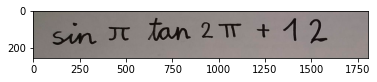

In [66]:
img2 = cv2.imread('test_images/bigger_sintan.png')
plt.imshow(img2)

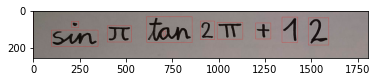

In [67]:
thresh2, joined_boxes2 = pildi_tootlus(img2)

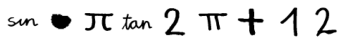

In [68]:
order_boxes(joined_boxes2)
draw_crops(make_square(get_crops(thresh2, joined_boxes2, False),45), draw_axis="off")

# Mudel ja treenimine

Mudeli treenimiseks kasutasime Kaggle'i andmestiku [Handwritten math symbols dataset](https://www.kaggle.com/xainano/handwrittenmathsymbols). See andmestik sisaldab nii matemaatilisi sümboleid kui ka numbreid ja mõningaid tähti. Pildid on suurusega 45x45.

Kasutasime Kaggle'i [postituses](https://www.kaggle.com/xainano/handwrittenmathsymbols/discussion/85277) esitatud skripti et puhastada andmestik duplikaatidest (üle 80% algandmetest).

Täpsem treenimine on nähtav Gitis: https://github.com/ilmaruduste/picture_calculator/blob/dev/math_symbol_classification_ml.ipynb

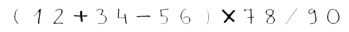

In [34]:
#Peame mudeli sisendiks tegema piltidel jooned õhemaks, kuna treening pildid on väga peenikeste joontega
kernel = np.ones((2,2),np.uint8)
dilated_crops = np.array([cv2.dilate(crop, kernel, iterations=2) for crop in tiny_crops])
draw_crops(dilated_crops, draw_axis="off")

predictions = loaded_model.predict(dilated_crops)
predictions = [np.array(prediction).argmax() for prediction in predictions]

In [35]:
tehe_pildil = true_labels[predictions]
tehe_pildil

array(['+', '1', '2', 'sin', '3', '4', 'div', '5', '6', '1', 'A', '7',
       '8', '1', '9', '6'], dtype=object)

Nagu näha, siis mudel ei suuda väga häesti ennustada, mis on piltidel, vähemalt mitte piisavalt hästi, et seda saaks sisendina kasutada kalkulaatoris.

# Kalkulaatorid
Projekti käigus valmis kaks kalkulaatori versiooni. Mõlemad kalkulaatorid võtavad sisendiks mudeli väljastatud listi pildilt leitud elementidest.

Üks kalkulaator võimaldab lihtsate tehete korral +-*/ võrrandis oleva suure A väärtust arvutada.

Teine kalkulaator võimaldab arvutada ilma muutujateta tehteid, tuvastab märke +-*/() sin tan cos pi.

## Võrrandi A suhtes lahendav kalkulaator

Kalkulaator eeldab, et A esineb ainult ühes kohas võrrandis.

In [37]:
def find_A(equation_list, eelmine_tehtepool = None, algne = None):
    if algne == None:
        algne = ''.join(equation_list)
    #ühenda täisarvud stringidena
    new_equation_list = []
    for i, element in enumerate(equation_list):
        try:
            #kui liitmistehe õnnestub, siis on tegu numbritega.
            number = int(new_equation_list[-1])+int(element)
            #eelmisele elemendile lisan uue elemendi
            new_equation_list[-1] = new_equation_list[-1]+str(element)
        except:
            #kui ei olnud number, või eelmine ei olnud number, siis lisan uue
            new_equation_list.append(element)
    equation_list = new_equation_list
        
    #panen kokku ühest tehtemärgist teise tehtemärgini, va =
    #esimene märk ei pruugi olla tehtemärk
    tehtemargid = [0]
    for i in range(len(equation_list)):
        if equation_list[i] in ["+","-","/","*"]:
            tehtemargid.append(i)
        #võrdusmärgi peaks teistest eraldama
        if equation_list[i] == "=":
            tehtemargid.append(i)
            tehtemargid.append(i+1)
    #viimane sümbol ei saa olla tehtemärk, aga on vaja teada mis oleks viimane sümbol
    tehtemargid.append(len(equation_list))
            
    tehted = []
    for i in range(len(tehtemargid)-1):
        tehted.append(''.join(equation_list[tehtemargid[i]:tehtemargid[i+1]]))
    #eemaldan null kirjed, mis tekivad kui esimene sümbol ON tehtemärk
    tehted = list(filter(None, tehted))
    
    #korrutamise ja jagamise tehted on keerulisemad
    korjag = []
    for i in range(len(tehted)):
        if tehted[i][0] in ["/","*"]:
            korjag[-1] = korjag[-1]+str(tehted[i])
        #peale 
        else:
            korjag.append(tehted[i])
    tehted = korjag
            
    #kus on A
    A_loc = [i for i, tehe in enumerate(tehted) if 'A' in tehe] #eeldan alguses et A on ainult 1
    A_element = tehted[A_loc[0]]
    
    #kus on =
    eq_loc = tehted.index('=')
    
    #jaotan tehte A-ga pooleks ja tehtega pooleks
    if A_loc[0] < eq_loc:
        A_pool = tehted[:eq_loc]
        tehte_pool = ''.join(tehted[eq_loc+1:])
    else:
        A_pool = tehted[eq_loc+1:]
        tehte_pool = ''.join(tehted[:eq_loc])
    
    #tõstan A-i poolelt ära kõik elemendid, mis ei sisalda A-i
    if len(A_pool) > 1:
        for element in A_pool:
            if element != A_element:
                tehte_pool = '('+tehte_pool+')'+switch_sign(element)
    
    A_pool = A_element        
    
    if "*" in A_pool:
        splititud = A_pool.split('*')
        for element in splititud:
            if "A" not in element:
                tehte_pool = '('+tehte_pool+')'+"/"+element
            if "A" in element:
                A_pool = element
    
    if "/" in A_pool:
        A_loc = A_pool.index("A")
        div_loc = A_pool.index('/')
        if A_loc < div_loc:
            splititud = A_pool.split('/')
            tehte_pool = '('+tehte_pool+')'+"*"+splititud[1]
            A_pool = splititud[0]
        else:
            splititud = A_pool.split('/')
            tehte_pool = splititud[0]+"/"+'('+tehte_pool+')'
            A_pool = splititud[1]
        
    if len(A_pool)>1: # peaks võimalik olema ainult siis, kui A-il on korrutusmärgita kordaja
        splititud = A_pool.split("A")
        for element in splititud:
            if element != '':
                if len(element)==1 and element.isdigit()==False:
                    element=element+"1"
                tehte_pool = '('+tehte_pool+')'+"/"+element
                A_pool = "A"
                
    if len(A_pool) == 1:
        return algne+ "   =>   A="+ str(eval(tehte_pool))
    else:
        vabandus = "Antud tehe on kalkulaatorile liiga keeruline. Vabandust." 
        lopp_tehe = A_pool +"="+tehte_pool
        return vabandus + "Jõudsin nii kaugele:" + lopp_tehe

def switch_sign(element):
    symbol = element[0]
    if symbol not in ["+","-","/","*"]:
        return '-'+element[0:]
    elif symbol == "+":
        return '-'+element[1:]
    elif symbol == "-":
        return '+'+element[1:]
    elif symbol == "*":
        return '/'+element[1:]
    elif symbol == "/":
        return '*'+element[1:]

In [38]:
model_output = ["A","-","7","=","1","2","3"]
print(find_A(model_output))
print("-----")
model_output = ["3","A","+","5","=","0","+","5"]
print(find_A(model_output))
print("-----")
model_output = ["6","*","A","+","5","+","5","=","7","2","/","6"]
print(find_A(model_output))
print("-----")
model_output = ["-","A","/","3","=","4"]
print(find_A(model_output))
print("-----")
model_output = ["5","=","-","15","/","3","A"]
print(find_A(model_output))
print("-----")
model_output = ["5","+","3","A", "+", "9","=","0"]
print(find_A(model_output))
print("-----")
model_output = list("6*A/7=1")
print(find_A(model_output))
print("-----")
model_output = list("6*3/2=A+5")
print(find_A(model_output))

A-7=123   =>   A=130
-----
3A+5=0+5   =>   A=0.0
-----
6*A+5+5=72/6   =>   A=0.3333333333333333
-----
-A/3=4   =>   A=-12.0
-----
5=-15/3A   =>   A=-1.0
-----
5+3A+9=0   =>   A=-4.666666666666667
-----
6*A/7=1   =>   A=1.1666666666666665
-----
6*3/2=A+5   =>   A=4.0


## Tehte kalkulaator

In [40]:
def calculate(equation_list,debug=False):
    #try:
        algne = equation_list.copy()
        
        if debug:
            print(''.join(equation_list))
                    
        #sin, cos, tan peaks leidma
        # trig funktsioonile järgnevast avaldisest kuni järgmise pluss, miinus märgini
        # v.a siis kui järgmine element on juba sulg
        for i, element in enumerate(equation_list):
            if element in ["sin","cos","tan"] and equation_list[i+1] != "(":
                equation_list.insert(i+1,"(")
                loppev_sulg_ix = find_next(equation_list, i, ["+","-","sin","cos","tan"])
                if loppev_sulg_ix != i:
                    equation_list.insert(loppev_sulg_ix,")")
                else:
                    equation_list.insert(len(equation_list),")")
        
        if debug:
            print(''.join(equation_list)) 
            
        #kui trig funktsioonide vahele oli pandud jagamis/kordusmärk, siis võis siin tekkida probleem "*)" või "/)"
        for i, element in enumerate(equation_list):
            if element == ")" and equation_list[i-1] in ["*","/"]:
                equation_list[i]=equation_list[i-1]
                equation_list[i-1]=")"
            
        #teatud tehted on ainult math moodulist
        for i, element in enumerate(equation_list):
            if element in ["sin","cos","tan", "pi"]:
                equation_list[i]="math."+equation_list[i]
        
        if debug:
            print(equation_list)            
            
        #math mooduli tehted võivad olla võrrandis järjest ilma korrutusmärgita, seda python ei oska lugeda
        # selleks hetkeks funktsioonis on kõigi math moodulite avaldised sulgudes
        
        for i, element in enumerate(equation_list):
            if "math" in element and i != 0 and equation_list[i-1] in [")","math.pi","0","1","2","3","4","5","6","7","8","9"]:
                equation_list.insert(i,"*")
            if element == "math.pi" and i != len(equation_list)-1 and equation_list[i+1] in ["(","math.pi","0","1","2","3","4","5","6","7","8","9"]:
                equation_list.insert(i+1,"*")
                
        if debug:
            print(equation_list)            
        
        return ''.join(''.join(algne)+"=>"+''.join(equation_list)+"="+ str(eval(''.join(equation_list))))
    #except:
     #   return "Antud tehe ei ole matemaatiliselt korrektne."

#tagastab järgmise lookup_symbol listi kuuluva elemendi indeksi
def find_next(equation_list, current_index, lookup_symbols):
    locations = [i for i, symbol in enumerate(equation_list) if symbol in lookup_symbols]
    next_index = current_index
    for index in locations:
        if index > next_index:
            return index
    return next_index

#tagastab eelmise lookup_symbol listi kuuluva elemendi indeksi
def find_prev(equation_list, current_index, lookup_symbols):
    locations = [i for i, symbol in enumerate(equation_list) if symbol in lookup_symbols]
    prev_index = current_index
    for index in locations:
        if index < prev_index:
            return index
    return prev_index

In [41]:
print(calculate(["cos","1","0","*","sin","1","0"]))
print(calculate(["tan","1","0","sin","1","0"]))
print(calculate(["cos","10","+","3","sin","10"]))
print(calculate(["sin","1","+","2"]))
print(calculate(["sin","1"]))
print(calculate(["pi","3"]))
print(calculate(["1","2","3","+","7"]))
print(calculate(["0","+","5","/","3"]))
print(calculate(["7","2","/","6","-","10","/","6"]))
print(calculate(["-","4","/","3"]))
print(calculate(["15","/","3","-","5"]))
print(calculate(["5","+","3", "+", "9"]))
print(calculate(list("6*1/7")))
print(calculate(list("6*3/2+5")))

cos10*sin10=>math.cos(10)*math.sin(10)=0.4564726253638138
tan10sin10=>math.tan(10)*math.sin(10)=-0.3527219776114433
cos10+3sin10=>math.cos(10)+3*math.sin(10)=-2.4711348617445617
sin1+2=>math.sin(1)+2=2.8414709848078967
sin1=>math.sin(1)=0.8414709848078965
pi3=>math.pi*3=9.42477796076938
123+7=>123+7=130
0+5/3=>0+5/3=1.6666666666666667
72/6-10/6=>72/6-10/6=10.333333333333334
-4/3=>-4/3=-1.3333333333333333
15/3-5=>15/3-5=0.0
5+3+9=>5+3+9=17
6*1/7=>6*1/7=0.8571428571428571
6*3/2+5=>6*3/2+5=14.0


# Kokkuvõte

Pildikalkulaatori tegemisel kõige keerulisemaks osaks sai mudeli treenimine/rakendamine.

Tekkinud probleemid:
* Mudeli treenimiseks kasutatud pildid erinevad palju enda tehtavatest piltidest.
* Erinevad kirjutusriistad teevad erineva jämedusega jooni.
* Andmestikus oli palju duplikaate.

Pilditöötluse osaga võib täitsa rahule jääda, kuna suutsime üpris hästi tuvastada kus asuvad numbrid ja märgid pildil. Kalkulaatorite jaoks algoritmide välja mõtlemine oli keerukas ja tundus nagu jalgratta leiutamine. Samas valminud kalkulaatorid, vähemalt meie testimise põhjal, töötavad nii nagu oodatud.

Rohkem koodi tehtud projekti kohta meie GitHubis https://github.com/ilmaruduste/picture_calculator.